reference video: https://www.youtube.com/watch?v=jztwpsIzEGc&t=981s

In [18]:
import cv2
from matplotlib import pyplot as plt

testing of representation of images into arrays of pixel values

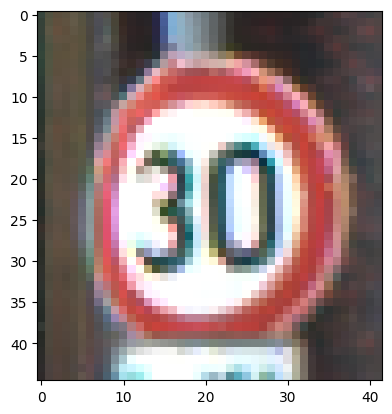

In [25]:
img=cv2.imread("../experimental/16_3399.png")
img.shape
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

We now try to take the data folder, and split it into multiple data folders, each of these folders containing one individual picture classification

In [48]:
import os
import shutil

classes=set()

for image in os.listdir("../images"):
    classes.add(image[:2])

newlist=[]


for classname in list(classes):
    newstring=""
    for char in classname:
        if char.isnumeric():
            newstring+=char
    newlist.append(int(newstring))


parent_dir="../experimental/data_classes"
imagePath="../images"

''' this creates folders and puts the images in the right classification folders
for num in (newlist):
    dir_path = os.path.join(parent_dir, str(num))
    os.makedirs(dir_path, exist_ok=False)
    
    print(f"Directory {dir_path} created.")


for imagefilename in os.listdir("../images"):
    newstring=""
    for char in imagefilename[:2]:
        if char.isnumeric():
            newstring+=char
    targetdirectory=os.path.join(parent_dir, newstring)
    newimagepath=os.path.join(imagePath, image)
    shutil.move(newimagepath, targetdirectory)
    print("image moved")
''''''







[8, 5, 7, 2, 11, 14, 15, 21, 18, 16, 22, 0, 17, 9, 3, 1, 19, 4, 13, 10, 6, 20, 12]
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image moved
image